# House Prices Prediction using Stacking Modeling

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

# Statistical library
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p

# Missing value visualization
import missingno as msno

# Seaborn configuration style
sns.set_style("darkgrid")

# Import data

In [2]:
# Read data
train_dataset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
# Dataset dimensions
print(f"Shape of the dataset: {train_dataset.shape}")
# Show data sample
train_dataset.head()

Shape of the dataset: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploration Data Analysis (EDA)

### Check duplicated Ids

In [3]:
print("There are {0} duplicated Ids".format(train_dataset['Id'].duplicated().sum()))
# Drop Id column
train_dataset = train_dataset.drop(['Id'], axis=1)

There are 0 duplicated Ids


### Check dataset dtype

In [ ]:
train_dataset.info()

## Exploring Sale Price column

In [ ]:
# Distribution of the sale price column
sns.kdeplot(
    data=train_dataset,
    x="SalePrice",    
    fill=True    
)

## Correlation between the features

In [ ]:
plt.subplots(figsize=(12,8))
sns.heatmap(data=train_dataset.corr(numeric_only=True), vmin=0.6)
plt.show()

**<p style="font-size:16px">Relationship between Sale Price and OverallQual, GrLivArea, GarageCars, and  GarageArea</p>**

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
sns.boxplot(x='OverallQual', y="SalePrice", data=train_dataset, ax=axs[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_dataset, ax=axs[0,1])
sns.boxplot(x='GarageCars', y="SalePrice", data=train_dataset, ax=axs[1,0])
sns.scatterplot(x='GarageArea', y="SalePrice", data=train_dataset, ax=axs[1,1])

## Remove outliers

In [4]:
train_dataset = train_dataset.loc[(train_dataset['SalePrice'] <= 600_000) & (train_dataset['GrLivArea'] <= 4000), :]
train_dataset = train_dataset.loc[(train_dataset['SalePrice'] <= 600_000) & (train_dataset['GarageArea'] <= 1200), :]
train_dataset = train_dataset.loc[(train_dataset['SalePrice'] <= 600_000) & (train_dataset['GarageCars'] <=4 ), :]
train_dataset.shape

(1450, 80)

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=train_dataset, x='GarageArea', y='SalePrice', hue='GarageCars', palette="Set2")
plt.show()

In [5]:
train_dataset = train_dataset.loc[train_dataset['GarageCars'] < 4, :]
train_dataset.shape

(1446, 80)

**<p style="font-size:16px">Convert Sale Price data to Gaussian distribution</p>**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


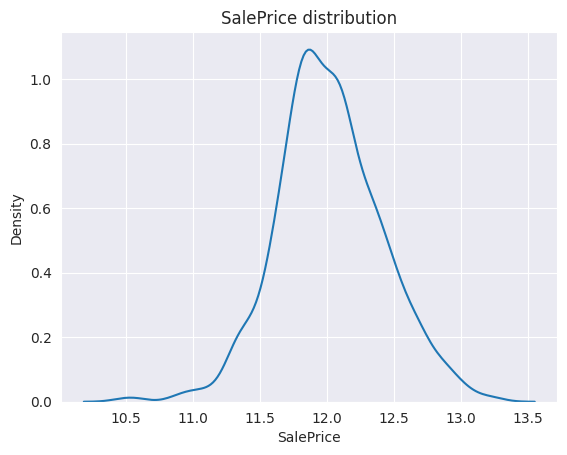

In [6]:
train_dataset['SalePrice'] = np.log1p(train_dataset['SalePrice'])

# New distribution 
sns.kdeplot(train_dataset['SalePrice'])
plt.title('SalePrice distribution')
plt.show()

## Missing values

In [ ]:
# Visualize missing values
msno.matrix(train_dataset)

In [ ]:
# Check the columns with missing values
print(train_dataset.columns[train_dataset.isna().sum() > 0])

**<p style="font-size:16px">Proportion of missing values in each column</p>**

In [7]:
def proportion_miss_values(column):
    miss_value_sum = train_dataset[column].isna().sum() 
    return pd.Series(miss_value_sum / train_dataset.shape[0], index=[column])

In [ ]:
proportion_df = pd.DataFrame([])
missing_columns = train_dataset.columns[train_dataset.isna().sum() > 0]
for i, column in enumerate(missing_columns):
    new_proportion = proportion_miss_values(column)
    proportion_df = pd.concat([proportion_df, new_proportion], axis=0)     

proportion_df.columns = ['miss_value_proportion']
proportion_df = proportion_df.sort_values('miss_value_proportion', ascending=False)
fig = plt.figure(figsize=(15,8))
sns.barplot(data=proportion_df, y=proportion_df.index, x='miss_value_proportion', palette="Blues_r", orient='h')
plt.xlabel("Miss Value Proportion")
plt.title("Miss Value Proportion by Columns")
plt.show()

**<p style="font-size:16px">Distribution of MasVnrArea and Count MasVnrType</p>**

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=train_dataset, x='MasVnrType', palette="Set2", ax=axs[0]).set_ylabel("Count of categories")
sns.histplot(train_dataset['MasVnrArea'], ax=axs[1])
plt.suptitle("Masonry veneer feature")
plt.show()

**<p style="font-size:16px">Distribution of LotArea and Count LotFrontage</p>**

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train_dataset, x='LotFrontage', kde=True, ax=axs[0])
sns.kdeplot(train_dataset['LotArea'], cut=1, log_scale=True, ax=axs[1])
plt.suptitle("Lot feature")
plt.show()

**<p style="font-size:16px">Count of Electrical feature</p>**

In [ ]:
plt.subplots(figsize=(15,5))
sns.countplot(data=train_dataset, x='Electrical')
plt.show()

**<p style="font-size:16px">Values to fill in missing values by columns</p>**

In [8]:
# Categorical columns where missing values were found
target_missing_columns = {
    "Alley": "No Alley",
    "LotFrontage": np.median(train_dataset[~train_dataset['LotFrontage'].isna()]['LotFrontage']),
    "MasVnrType": "None",
    "BsmtQual": "No basement",
    "BsmtCond": "No basement",
    "BsmtExposure": "No basement",
    "BsmtFinType1": "No basement",
    "BsmtFinType2": "No basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None",
    "Electrical": "SBrkr"
}
# Dependent columns
missing_dependent_columns = {
    "MasVnrArea": ["MasVnrType", "None"],
    "GarageYrBlt": ["GarageType", "No Garage"]    
}

### Handling missing categories

In [9]:
for column, fill_value in target_missing_columns.items():    
    train_dataset[column] = train_dataset[column].fillna(fill_value) 

### Handling missing values of dependent columns

In [10]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    train_dataset.loc[train_dataset[column] == value, dependent_column] = 0    

In [ ]:
# Visualize missing values
msno.matrix(train_dataset)

## Correction of fields

**<p style="font-size:16px">Convert all the categorical columns to object type</p>**

In [11]:
# Categorical columns
categorical_columns = (
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", \
    "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", \
    "KitchenQual", "Functional", \
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", \
    "MiscFeature", "YrSold", "SaleType", "SaleCondition"    
)
# Columns with natural label encoder
auto_label_encoder = [
    "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", \
    "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", \
    "Fireplaces", "GarageCars", "MoSold"
]

In [ ]:
# Check types of auto label encode columns
train_dataset[list(auto_label_encoder)].dtypes

In [12]:
def change_dtype(dataset, column, type):
    """
        To change the type of the columns of the dataset
        Args:
            dataset (pandas DataFrame)
            column (string): Columns to change
            type (string): New type for the columns
    """
    return dataset[column].astype(type)

# Convert to categorical type
for cat_column in categorical_columns:
    train_dataset[cat_column] = change_dtype(train_dataset, cat_column, "object")

In [ ]:
train_dataset.info()

# Preprocessing Data

In [13]:
# Get the features and labels
X = train_dataset.iloc[:, :-1]
y = train_dataset.iloc[:, -1]

## Convert to Label Encoder

<p style="font-size:16px">Target features to label encoding</p>

In [14]:
# List of categorical columns to Label Encoder
target_le_columns = (
    "MSSubClass", "LotShape", "LandContour", "LandSlope", \
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", \
    "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", \
    "GarageCond", "PavedDrive", "PoolQC", "Fence", "YrSold"    
)

**Apply Label Encoder to the data**

In [15]:
from sklearn.preprocessing import LabelEncoder

for column in target_le_columns:
    # Encoder
    encoder = LabelEncoder()    
    X[column] = encoder.fit_transform(X[column].values)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5,RL,65.0,8450,Pave,No Alley,3,3,AllPub,Inside,...,0,0,3,4,None,0,2,2,WD,Normal
1,0,RL,80.0,9600,Pave,No Alley,3,3,AllPub,FR2,...,0,0,3,4,None,0,5,1,WD,Normal
2,5,RL,68.0,11250,Pave,No Alley,0,3,AllPub,Inside,...,0,0,3,4,None,0,9,2,WD,Normal
3,6,RL,60.0,9550,Pave,No Alley,0,3,AllPub,Corner,...,0,0,3,4,None,0,2,0,WD,Abnorml
4,5,RL,84.0,14260,Pave,No Alley,0,3,AllPub,FR2,...,0,0,3,4,None,0,12,2,WD,Normal


**<p style="font-size:16px">Check skewness of the features</p>**

In [16]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.362801
PoolArea,17.443752
LotArea,12.690108
3SsnPorch,10.242946
LowQualFinSF,8.957238
LandSlope,4.820239
KitchenAbvGr,4.540317
BsmtFinSF2,4.227465
BsmtHalfBath,4.140732
ScreenPorch,4.094910


**<p style="font-size:16px">Convert to a Gaussian distribution</p>**

In [17]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to correct".format(skewness.shape[0]))

skewed_features = skewness.index

for feat in skewed_features:    
    X[feat] = np.log1p(X[feat])

There are 55 skewed numerical features to correct


**<p style="font-size:16px">Convert categorical variables to dummies</p>**

In [18]:
X = pd.get_dummies(X)
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.791759,4.189655,9.042040,1.386294,1.386294,0.0,2.079442,1.791759,7.602900,7.602900,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.394449,9.169623,1.386294,1.386294,0.0,1.945910,2.197225,7.589336,7.589336,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.234107,9.328212,0.000000,1.386294,0.0,2.079442,1.791759,7.601902,7.602401,...,False,False,False,True,False,False,False,False,True,False
3,1.945910,4.110874,9.164401,0.000000,1.386294,0.0,2.079442,1.791759,7.557995,7.586296,...,False,False,False,True,True,False,False,False,False,False
4,1.791759,4.442651,9.565284,0.000000,1.386294,0.0,2.197225,1.791759,7.601402,7.601402,...,False,False,False,True,False,False,False,False,True,False


In [19]:
X = X.reset_index(drop=True)

In [20]:
new_column = pd.Series([False] * X.shape[0], name='Condition2_PosN')

In [ ]:
print(new_column)

In [21]:
# Fill mising columns after dummies convertion
first_div_X = X.iloc[:,:109]
print(first_div_X.shape)
print(first_div_X.shape)
second_div_X = X.iloc[:,109:]
print(second_div_X.shape)
first_div_X = pd.concat([first_div_X, new_column], axis=1)
X = pd.concat([first_div_X, second_div_X], axis=1)
X.head()

(1446, 109)
(1446, 109)
(1446, 118)


,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.791759,4.189655,9.042040,1.386294,1.386294,0.0,2.079442,1.791759,7.602900,7.602900,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.394449,9.169623,1.386294,1.386294,0.0,1.945910,2.197225,7.589336,7.589336,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.234107,9.328212,0.000000,1.386294,0.0,2.079442,1.791759,7.601902,7.602401,...,False,False,False,True,False,False,False,False,True,False
3,1.945910,4.110874,9.164401,0.000000,1.386294,0.0,2.079442,1.791759,7.557995,7.586296,...,False,False,False,True,True,False,False,False,False,False
4,1.791759,4.442651,9.565284,0.000000,1.386294,0.0,2.197225,1.791759,7.601402,7.601402,...,False,False,False,True,False,False,False,False,True,False


# Ensemble Modeling

In [22]:
# Base models
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Meta-learner
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

## Possible Base models

**All the hyperparameters was found with GridSearchCV**

In [23]:
# Lasso model
lasso = Lasso(alpha=0.0005, selection="random", random_state=10)
# Ridge model
ridge = Ridge(alpha=0.5, solver="lsqr", random_state=11)
# ElasticNet model
elastic_net = ElasticNet(alpha=0.0005, l1_ratio=1.0, selection="random", random_state=12)
# SVM model
svr = SVR(C=0.05, kernel="linear", gamma="scale")
# KNN model
knn = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="manhattan", algorithm="auto")
# Random Forest model
rf = RandomForestRegressor(
    n_estimators=3000,
    max_depth=7,
    min_samples_leaf=15,
    min_samples_split=10,
    random_state=14
)
# XGBoost model
xgboost = XGBRegressor(
    learning_rate=0.01,
    n_estimators=6000,
    max_depth=4,
    objective='reg:squarederror',
    nthread=-1,
    random_state=15
)

### Meta-learner

In [24]:
# GradientBoosting model
gbr = GradientBoostingRegressor(
    n_estimators=3000,
    max_depth=5,
    min_samples_leaf=15,
    min_samples_split=10,
    loss="huber",
    max_features="sqrt",
    random_state=15
)

### Perform Cross-validation to Identify the best base models

In [25]:
from sklearn.model_selection import KFold
# Set the Folds
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)

In [26]:
X_train_folds, X_test_folds = [], []
y_train_folds, y_test_folds = [], []
# Get the splitted data
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    X_train_folds.append(X.iloc[train_index])
    X_test_folds.append(X.iloc[test_index])
    y_train_folds.append(y.iloc[train_index])
    y_test_folds.append(y.iloc[test_index])

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [ ]:
print("Train sample: \n")
print(train_index[:10])
print("Test sample: \n")
print(test_index[:10])

In [ ]:
print(f"Shape of X train folds: {len(X_train_folds)}x{len(X_train_folds[0])}, Shape of X test folds: {len(X_test_folds)}x{len(X_test_folds[0])}")

### Train and Test base models

In [27]:
# Save the scores of the models
scores = np.empty((7, n_folds))
# Save the rmse of the models
rmse = np.empty((7, n_folds))

test_predictions = pd.DataFrame([])
train_predictions = pd.DataFrame([])

for i, (X_train, X_test, y_train, y_test) in enumerate(zip(X_train_folds, X_test_folds, y_train_folds, y_test_folds)):    
    print(f"Fold {i}")   
    
    # Scale the feature data
    rs = RobustScaler()    
    scaled_X_train = rs.fit_transform(X_train)
    scaled_X_test = rs.transform(X_test)
    
    # Train the base models with the current fold
    lasso.fit(scaled_X_train, y_train)
    ridge.fit(scaled_X_train, y_train)
    svr.fit(scaled_X_train, y_train)
    elastic_net.fit(scaled_X_train, y_train)
    knn.fit(scaled_X_train, y_train)    
    rf.fit(X_train, y_train)
    xgboost.fit(X_train, y_train)
    
    # Compute the score, predictions of current test fold, and rmse of the models
    
    scores[0, i] = lasso.score(scaled_X_test, y_test)
    lasso_pred = lasso.predict(scaled_X_test)    
    rmse[0, i] = np.sqrt(mean_squared_error(y_test, lasso_pred))

    scores[1, i] = ridge.score(scaled_X_test, y_test)
    ridge_pred = ridge.predict(scaled_X_test)    
    rmse[1, i] = np.sqrt(mean_squared_error(y_test, ridge_pred))

    scores[2, i] = svr.score(scaled_X_test, y_test)
    svr_pred = svr.predict(scaled_X_test)    
    rmse[2, i] = np.sqrt(mean_squared_error(y_test, svr_pred))

    scores[3, i] = elastic_net.score(scaled_X_test, y_test)
    elastic_net_pred = elastic_net.predict(scaled_X_test)
    rmse[3, i] = np.sqrt(mean_squared_error(y_test, elastic_net_pred))

    scores[4, i] = knn.score(scaled_X_test, y_test)
    knn_pred = knn.predict(scaled_X_test)
    rmse[4, i] = np.sqrt(mean_squared_error(y_test, knn_pred))

    scores[5, i] = xgboost.score(X_test, y_test)
    xgboost_pred = xgboost.predict(X_test)
    rmse[5, i] = np.sqrt(mean_squared_error(y_test, xgboost_pred))

    scores[6, i] = rf.score(X_test, y_test)
    rf_pred = rf.predict(X_test)
    rmse[6, i] = np.sqrt(mean_squared_error(y_test, rf_pred))
    
    # Concatenate the predictions    
    temp_test_predictions = pd.DataFrame({
        "Lasso": lasso_pred,
        "Ridge": ridge_pred,
        "SVR": svr_pred,
        "ElasticNet": elastic_net_pred,
        "KNN": knn_pred,
        "XGBoost": xgboost_pred,
        "RF": rf_pred,
        "y_test": y_test
    })
    
    test_predictions = pd.concat([test_predictions, temp_test_predictions], axis=0)
        
    lasso_pred = lasso.predict(scaled_X_train)
    ridge_pred = ridge.predict(scaled_X_train)
    svr_pred = svr.predict(scaled_X_train)
    elastic_net_pred = elastic_net.predict(scaled_X_train)
    knn_pred = knn.predict(scaled_X_train)
    xgboost_pred = xgboost.predict(X_train)
    rf_pred = rf.predict(X_train)
    
    # Concatenate the train predictions
    temp_train_predictions = pd.DataFrame({
        "Lasso": lasso_pred,
        "Ridge": ridge_pred,
        "SVR": svr_pred,
        "ElasticNet": elastic_net_pred,
        "KNN": knn_pred,
        "XGBoost": xgboost_pred,
        "RF": rf_pred,
        "y_train": y_train
    })    
    train_predictions = pd.concat([train_predictions, temp_train_predictions], axis=0)
    
test_predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "KNN", "XGBoost", "RF", "y_test"]   
train_predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "KNN", "XGBoost", "RF", "y_train"]  



Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [28]:
print(f"Lasso mean score: {scores[0].mean()}, Lasso std: {scores[0].std()}, RMSE: {rmse[0].mean()}, {rmse[0].std()}")
print(f"Ridge mean score: {scores[1].mean()}, Ridge std: {scores[1].std()}, RMSE: {rmse[1].mean()}, {rmse[1].std()}")
print(f"SVM mean score: {scores[2].mean()}, SVM std: {scores[2].std()}, RMSE: {rmse[2].mean()}, {rmse[2].std()}")
print(f"ElasticNet mean score: {scores[3].mean()}, ElasticNet std: {scores[3].std()}, RMSE: {rmse[3].mean()}, {rmse[3].std()}")
print(f"KNN mean score: {scores[4].mean()}, KNN std: {scores[4].std()}, RMSE: {rmse[4].mean()}, {rmse[4].std()}")
print(f"Xgboost mean score: {scores[5].mean()}, XGBoost std: {scores[5].std()}, RMSE: {rmse[5].mean()}, {rmse[5].std()}")
print(f"Random Forest mean score: {scores[6].mean()}, Random Forest std: {scores[6].std()}, RMSE: {rmse[6].mean()}, {rmse[6].std()}")

Lasso mean score: 0.9182431441510668, Lasso std: 0.011910532150851246, RMSE: 0.11165677433159873, 0.00953262456916706
Ridge mean score: 0.9137778933282501, Ridge std: 0.013884988549353855, RMSE: 0.11464955458800005, 0.011265448126802751
SVM mean score: 0.9118193767690604, SVM std: 0.015337139199045008, RMSE: 0.1158830197161399, 0.01202742917820972
ElasticNet mean score: 0.9182430491384179, ElasticNet std: 0.011910400077236245, RMSE: 0.1116568505420319, 0.009532591223488197
KNN mean score: 0.8158221230619643, KNN std: 0.028706311791288856, RMSE: 0.1680424582477587, 0.019816048810068633
Xgboost mean score: 0.9038834740344104, XGBoost std: 0.018174619557381134, RMSE: 0.12080976312131583, 0.012413886498746632
Random Forest mean score: 0.8418971747094659, Random Forest std: 0.017923953355087997, RMSE: 0.15541688068413528, 0.010662711275238324


# Train the meta-learner

In [29]:
# Train the meta-learner with the base model predictions of the test folds
good_predictors = ["Lasso", "Ridge", "SVR", "ElasticNet", "XGBoost"]
gbr.fit(test_predictions.loc[:,good_predictors], test_predictions.iloc[:,-1]) 

GradientBoostingRegressor(loss='huber', max_depth=5, max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=3000, random_state=15)

Train Predictions

In [30]:
gbr_pred = gbr.predict(train_predictions.loc[:,good_predictors])

In [31]:
print("GBR model score: {0}, GBR model RMSE: {1}".format(gbr.score(train_predictions.loc[:,good_predictors], train_predictions.iloc[:,-1]), np.sqrt(mean_squared_error(train_predictions.iloc[:,-1], gbr_pred))))

GBR model score: 0.9472381207914683, GBR model RMSE: 0.0902064206604743


# Predict with submission data

In [59]:
# Read data
submission_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# Dataset dimensions
print(f"Shape of the submission data: {submission_data.shape}")
# Show data sample
submission_data.head()

Shape of the submission data: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [60]:
print("There are {0} duplicated Ids".format(submission_data['Id'].duplicated().sum()))
# Save Id's
submission_data_Id = submission_data['Id']
# Drop Id column
submission_data = submission_data.drop(['Id'], axis=1)

There are 0 duplicated Ids


<Axes: >

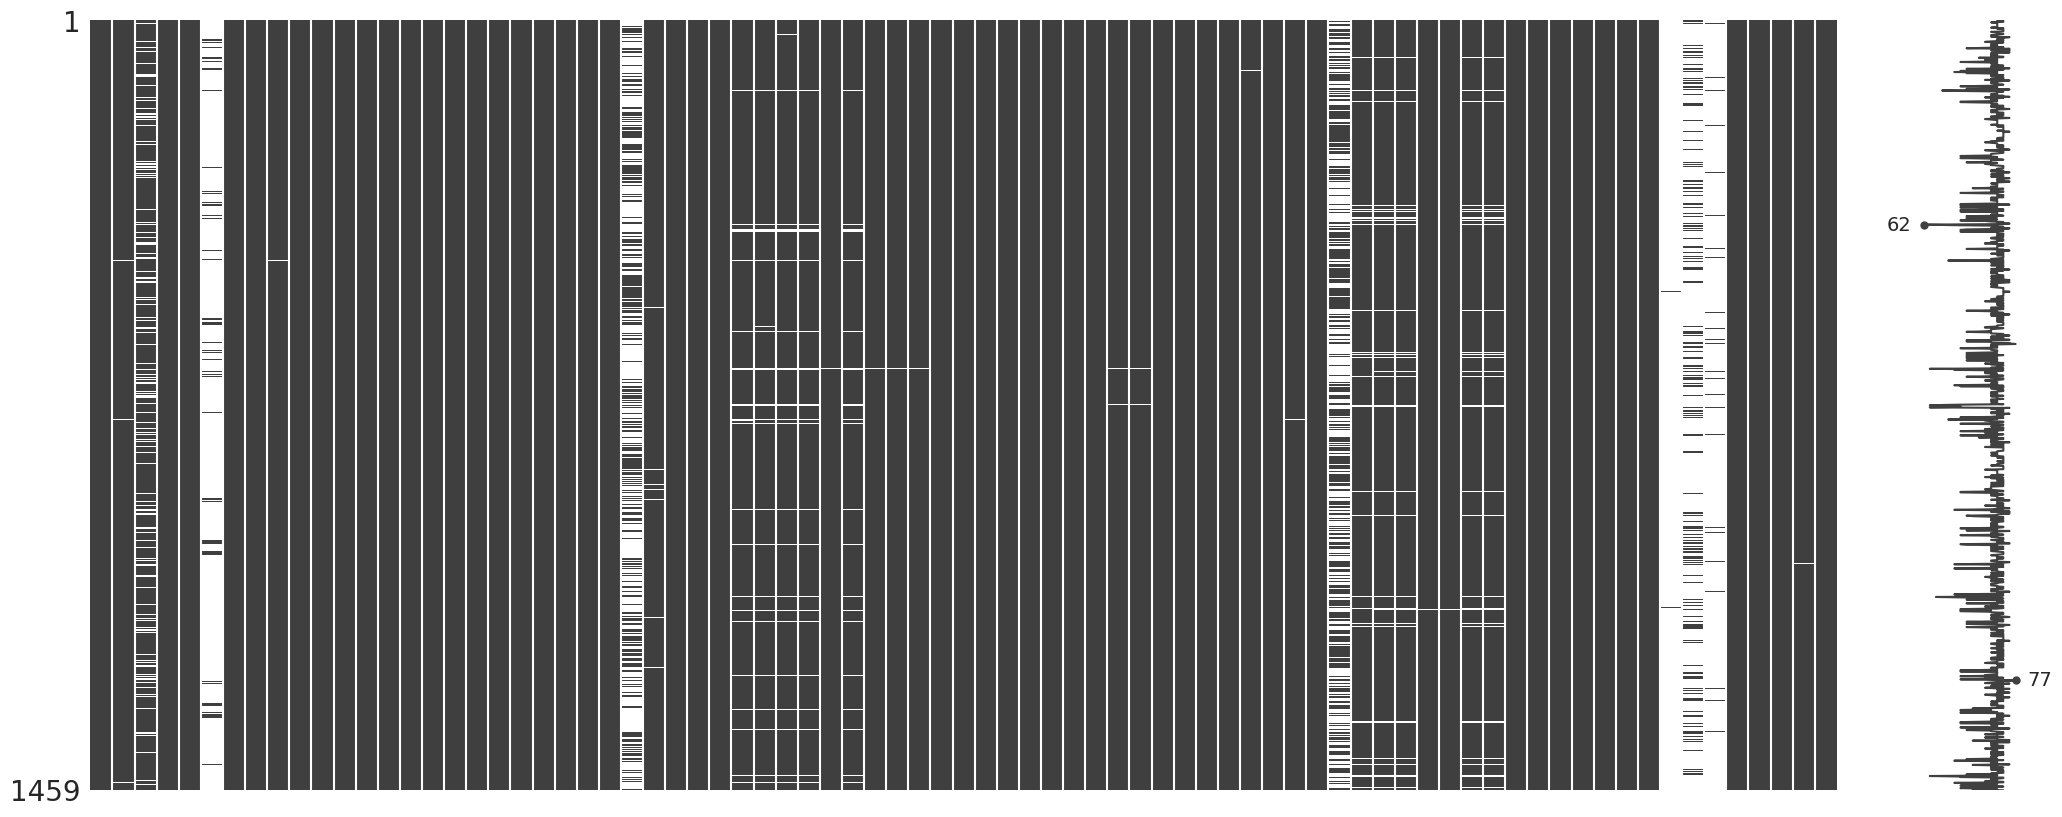

In [34]:
# Visualize missing values
msno.matrix(submission_data)

In [ ]:
# Check the columns with missing values
print(submission_data.columns[submission_data.isna().sum() > 0])

In [ ]:
def proportion_miss_values(column):
    miss_value_sum = submission_data[column].isna().sum() 
    return pd.Series(miss_value_sum / submission_data.shape[0], index=[column])

In [ ]:
proportion_df = pd.DataFrame([])
missing_columns = submission_data.columns[submission_data.isna().sum() > 0]
for i, column in enumerate(missing_columns):
    new_proportion = proportion_miss_values(column)
    proportion_df = pd.concat([proportion_df, new_proportion], axis=0)     

proportion_df.columns = ['miss_value_proportion']
proportion_df = proportion_df.sort_values('miss_value_proportion', ascending=False)
fig = plt.figure(figsize=(15,8))
sns.barplot(data=proportion_df, y=proportion_df.index, x='miss_value_proportion', palette="Blues_r", orient='h')
plt.xlabel("Miss Value Proportion")
plt.title("Miss Value Proportion by Columns")
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=submission_data, x='LotFrontage', ax=axs[0], kde=True)
sns.kdeplot(submission_data['LotArea'], cut=1, log_scale=True, ax=axs[1])
plt.suptitle("Lot feature")
plt.show()

In [35]:
# Categorical columns where missing values were found
target_missing_columns = {
    "Alley": "No Alley",
    "LotFrontage": np.median(submission_data[~submission_data['LotFrontage'].isna()]['LotFrontage']),
    "MasVnrType": "None",
    "BsmtQual": "No basement",
    "BsmtCond": "No basement",
    "BsmtExposure": "No basement",
    "BsmtFinType1": "No basement",
    "BsmtFinType2": "No basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None",
    "Electrical": "SBrkr"
}
# Dependent columns
missing_dependent_columns = {
    "MasVnrArea": ["MasVnrType", "None"],
    "GarageYrBlt": ["GarageType", "No Garage"]    
}

In [36]:
for column, fill_value in target_missing_columns.items():    
    submission_data[column] = submission_data[column].fillna(fill_value) 

for dependent_column, (column, value) in missing_dependent_columns.items():
    submission_data.loc[submission_data[column] == value, dependent_column] = 0 

In [ ]:
# Visualize missing values
msno.matrix(submission_data)

In [ ]:
# Check the columns with missing values
print(submission_data.columns[submission_data.isna().sum() > 0])

In [ ]:
submission_data.loc[submission_data['BsmtFinSF1'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

In [ ]:
submission_data.loc[submission_data['BsmtFinSF2'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

In [ ]:
submission_data.loc[submission_data['BsmtUnfSF'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

In [ ]:
submission_data.loc[submission_data['TotalBsmtSF'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

In [ ]:
submission_data.loc[submission_data['BsmtFullBath'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

In [ ]:
submission_data.loc[submission_data['BsmtHalfBath'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

In [ ]:
submission_data.loc[submission_data['KitchenQual'].isna(), ['KitchenAbvGr', 'OverallQual']]

In [ ]:
submission_data.loc[submission_data['GarageYrBlt'].isna(), ['GarageCars', 'GarageArea']]

In [ ]:
submission_data.loc[submission_data['GarageCars'].isna(), ['GarageYrBlt', 'GarageArea', 'GarageType', "GarageFinish", 'GarageQual']]

In [37]:
submission_data.at[1116,'GarageYrBlt'] = 0.0
submission_data.at[1116,'GarageType'] = "No Garage"

In [ ]:
submission_data.loc[submission_data['GarageYrBlt'].isna(), ['YearBuilt', 'YearRemodAdd',"YrSold"]]

In [38]:
submission_data.at[666,'GarageYrBlt'] = 1910.0

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(12, 10))
sns.countplot(data=submission_data, x='MSZoning', ax=axs[0,0])
sns.countplot(data=submission_data, x='Utilities', ax=axs[0,1])
sns.kdeplot(data=submission_data, x='BsmtFinSF1', ax=axs[1,0])
sns.kdeplot(data=submission_data, x='BsmtFinSF2', ax=axs[1,1])
sns.kdeplot(data=submission_data, x='BsmtUnfSF', ax=axs[2,0])
sns.kdeplot(data=submission_data, x='TotalBsmtSF', ax=axs[2,1])
sns.countplot(data=submission_data, x='Functional', ax=axs[3,0])
sns.countplot(data=submission_data, x='SaleType', ax=axs[3,1])
sns.countplot(data=submission_data, x='Exterior1st', ax=axs[4,0])
sns.countplot(data=submission_data, x='Exterior2nd', ax=axs[4,1])

for ax in axs[4]:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Distribution and count of missing values in target columns")
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

In [39]:
target_missing_columns = {
    "MSZoning": "RL",
    "Utilities": "AllPub",
    "Exterior1st": "VinylSd",
    "Exterior2nd": "VinylSd",    
    "Functional": "Typ",
    "SaleType": "WD",
    "KitchenQual": "TA",    
}

# Dependent columns
missing_dependent_columns = {
    "BsmtFinSF1": ["BsmtFinType1", "No basement"],
    "BsmtFinSF2": ["BsmtFinType2", "No basement"],
    "BsmtUnfSF": ["BsmtFinType1", "No basement"],
    "TotalBsmtSF": ["BsmtFinType1", "No basement"],
    "BsmtFullBath": ["BsmtFinType1", "No basement"],
    "BsmtHalfBath": ["BsmtFinType1", "No basement"],
    "GarageCars": ["GarageQual", "No Garage"],
    "GarageArea": ["GarageQual", "No Garage"]       
}

In [40]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    submission_data.loc[submission_data[column] == value, dependent_column] = 0 

for column, fill_value in target_missing_columns.items():    
    submission_data[column] = submission_data[column].fillna(fill_value) 

In [ ]:
# Visualize missing values
msno.matrix(submission_data)

In [41]:
# Categorical columns
categorical_columns = (
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", \
    "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", \
    "KitchenQual", "Functional", \
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", \
    "MiscFeature", "YrSold", "SaleType", "SaleCondition"    
)
# Columns with natural label encoder
auto_label_encoder = [
    "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", \
    "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", \
    "Fireplaces", "GarageCars", "MoSold"
]

In [42]:
def change_dtype(dataset, column, type):
    """
        To change the type of the columns of the dataset
        Args:
            dataset (pandas DataFrame)
            column (string): Columns to change
            type (string): New type for the columns
    """
    return dataset[column].astype(type)

# Convert to categorical type
for cat_column in categorical_columns:
    submission_data[cat_column] = change_dtype(submission_data, cat_column, "object")

In [43]:
# List of categorical columns to Label Encoder
target_le_columns = (
    "MSSubClass", "LotShape", "LandContour", "LandSlope", \
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", \
    "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", \
    "GarageCond", "PavedDrive", "PoolQC", "Fence", "YrSold"    
)

In [44]:
from sklearn.preprocessing import LabelEncoder

for column in target_le_columns:
    # Encoder
    encoder = LabelEncoder()    
    submission_data[column] = encoder.fit_transform(submission_data[column].values)
submission_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,RH,80.0,11622,Pave,No Alley,3,3,AllPub,Inside,...,120,0,2,2,None,0,6,4,WD,Normal
1,0,RL,81.0,14267,Pave,No Alley,0,3,AllPub,Corner,...,0,0,2,4,Gar2,12500,6,4,WD,Normal
2,5,RL,74.0,13830,Pave,No Alley,0,3,AllPub,Inside,...,0,0,2,2,None,0,3,4,WD,Normal
3,5,RL,78.0,9978,Pave,No Alley,0,3,AllPub,Inside,...,0,0,2,4,None,0,6,4,WD,Normal
4,11,RL,43.0,5005,Pave,No Alley,0,1,AllPub,Inside,...,144,0,2,4,None,0,1,4,WD,Normal


In [45]:
numeric_feats = submission_data.dtypes[submission_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = submission_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,20.176117
MiscVal,20.054543
LowQualFinSF,16.150628
3SsnPorch,12.511336
LandSlope,4.963280
EnclosedPorch,4.664371
KitchenAbvGr,4.074860
BsmtFinSF2,4.038796
ScreenPorch,3.784349
BsmtHalfBath,3.779085


In [46]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to correct".format(skewness.shape[0]))

skewed_features = skewness.index

for feat in skewed_features:    
    submission_data[feat] = np.log1p(submission_data[feat])

There are 55 skewed numerical features to correct


In [47]:
submission_data = pd.get_dummies(submission_data)
submission_data.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,4.394449,9.360741,1.386294,1.386294,0.0,1.791759,1.945910,7.581720,7.581720,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.406719,9.565775,0.000000,1.386294,0.0,1.945910,1.945910,7.580189,7.580189,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.317488,9.534668,0.000000,1.386294,0.0,1.791759,1.791759,7.599902,7.600402,...,False,False,False,True,False,False,False,False,True,False
3,1.791759,4.369448,9.208238,0.000000,1.386294,0.0,1.945910,1.945910,7.600402,7.600402,...,False,False,False,True,False,False,False,False,True,False
4,2.484907,3.784190,8.518392,0.000000,0.693147,0.0,2.197225,1.791759,7.597396,7.597396,...,False,False,False,True,False,False,False,False,True,False


In [48]:
train_columns = X.columns
train_columns = train_columns[:-1]
submission_columns = submission_data.columns
missing_columns = [(i,col) for i,col in enumerate(train_columns) if col not in submission_columns]
print(missing_columns)

[(66, 'Utilities_NoSeWa'), (111, 'Condition2_RRAe'), (112, 'Condition2_RRAn'), (113, 'Condition2_RRNn'), (122, 'HouseStyle_2.5Fin'), (134, 'RoofMatl_Membran'), (135, 'RoofMatl_Metal'), (136, 'RoofMatl_Roll'), (147, 'Exterior1st_ImStucc'), (150, 'Exterior1st_Stone'), (164, 'Exterior2nd_Other'), (181, 'Heating_Floor'), (185, 'Heating_OthW'), (192, 'Electrical_Mix'), (212, 'MiscFeature_TenC')]


In [49]:
new_column = pd.Series([False] * submission_data.shape[0])
for column in missing_columns:    
    submission_data.insert(loc=column[0], column=column[1], value=new_column)    

In [50]:
train_columns = X.columns
train_columns = train_columns[:-1]
submission_columns = submission_data.columns
missing_columns = [(i,col) for i,col in enumerate(submission_columns) if col not in train_columns]
print(missing_columns)

[(227, 'SaleCondition_Partial')]


In [51]:
# Fill mising columns after dummies convertion
Condition2_PosN_column = submission_data.iloc[:,110]
Condition2_PosA_column = submission_data.iloc[:,109]
first_div_subm = submission_data.iloc[:,:109]
second_div_subm = submission_data.iloc[:,111:]
first_div_subm = pd.concat([first_div_subm, Condition2_PosN_column], axis=1)
first_div_subm = pd.concat([first_div_subm, Condition2_PosA_column], axis=1)
submission_data = pd.concat([first_div_subm, second_div_subm], axis=1)
submission_data.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,4.394449,9.360741,1.386294,1.386294,0.0,1.791759,1.945910,7.581720,7.581720,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.406719,9.565775,0.000000,1.386294,0.0,1.945910,1.945910,7.580189,7.580189,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.317488,9.534668,0.000000,1.386294,0.0,1.791759,1.791759,7.599902,7.600402,...,False,False,False,True,False,False,False,False,True,False
3,1.791759,4.369448,9.208238,0.000000,1.386294,0.0,1.945910,1.945910,7.600402,7.600402,...,False,False,False,True,False,False,False,False,True,False
4,2.484907,3.784190,8.518392,0.000000,0.693147,0.0,2.197225,1.791759,7.597396,7.597396,...,False,False,False,True,False,False,False,False,True,False


In [52]:
scaled_submission_data = rs.transform(submission_data)

lasso_pred = lasso.predict(scaled_submission_data)
ridge_pred = ridge.predict(scaled_submission_data)
svr_pred = svr.predict(scaled_submission_data)
elastic_net_pred = elastic_net.predict(scaled_submission_data)
xgboost_pred = xgboost.predict(submission_data)

predictions = pd.DataFrame({
    "Lasso": lasso_pred,
    "Ridge": ridge_pred,
    "SVR": svr_pred,
    "ElasticNet": elastic_net_pred,
    "XGBoost": xgboost_pred
}) 

final_predictions = gbr.predict(predictions)

In [57]:
final_predictions = np.expm1(final_predictions)

In [61]:
submission = pd.DataFrame()
submission['Id'] = submission_data_Id
submission['SalePrice'] = final_predictions
submission.to_csv('submission.csv',index=False)


In [62]:
submission

,Id,SalePrice
0,1461,128249.020059
1,1462,160866.019648
2,1463,181874.479672
3,1464,193539.188709
4,1465,183753.010788
...,...,...
1454,2915,78312.107641
1455,2916,89966.521975
1456,2917,165403.908245
1457,2918,130752.019860
